# Import Necessary Packages

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import warnings
from scipy import stats
from pmdarima.arima import ARIMA

# Load the Dataset for Stock Closing Prices

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="No supported index is available")


start = datetime(2020, 5, 1)
end   = datetime(2025, 4, 30)
tickers = ['MSFT', 'JPM', 'XOM', 'CAT', 'PG']

close_data = pd.DataFrame({
    t: web.DataReader(t, 'stooq', start, end)['Close'].sort_index()
    for t in tickers
}).dropna()

# Auto ARIMA Model with forecasts plots

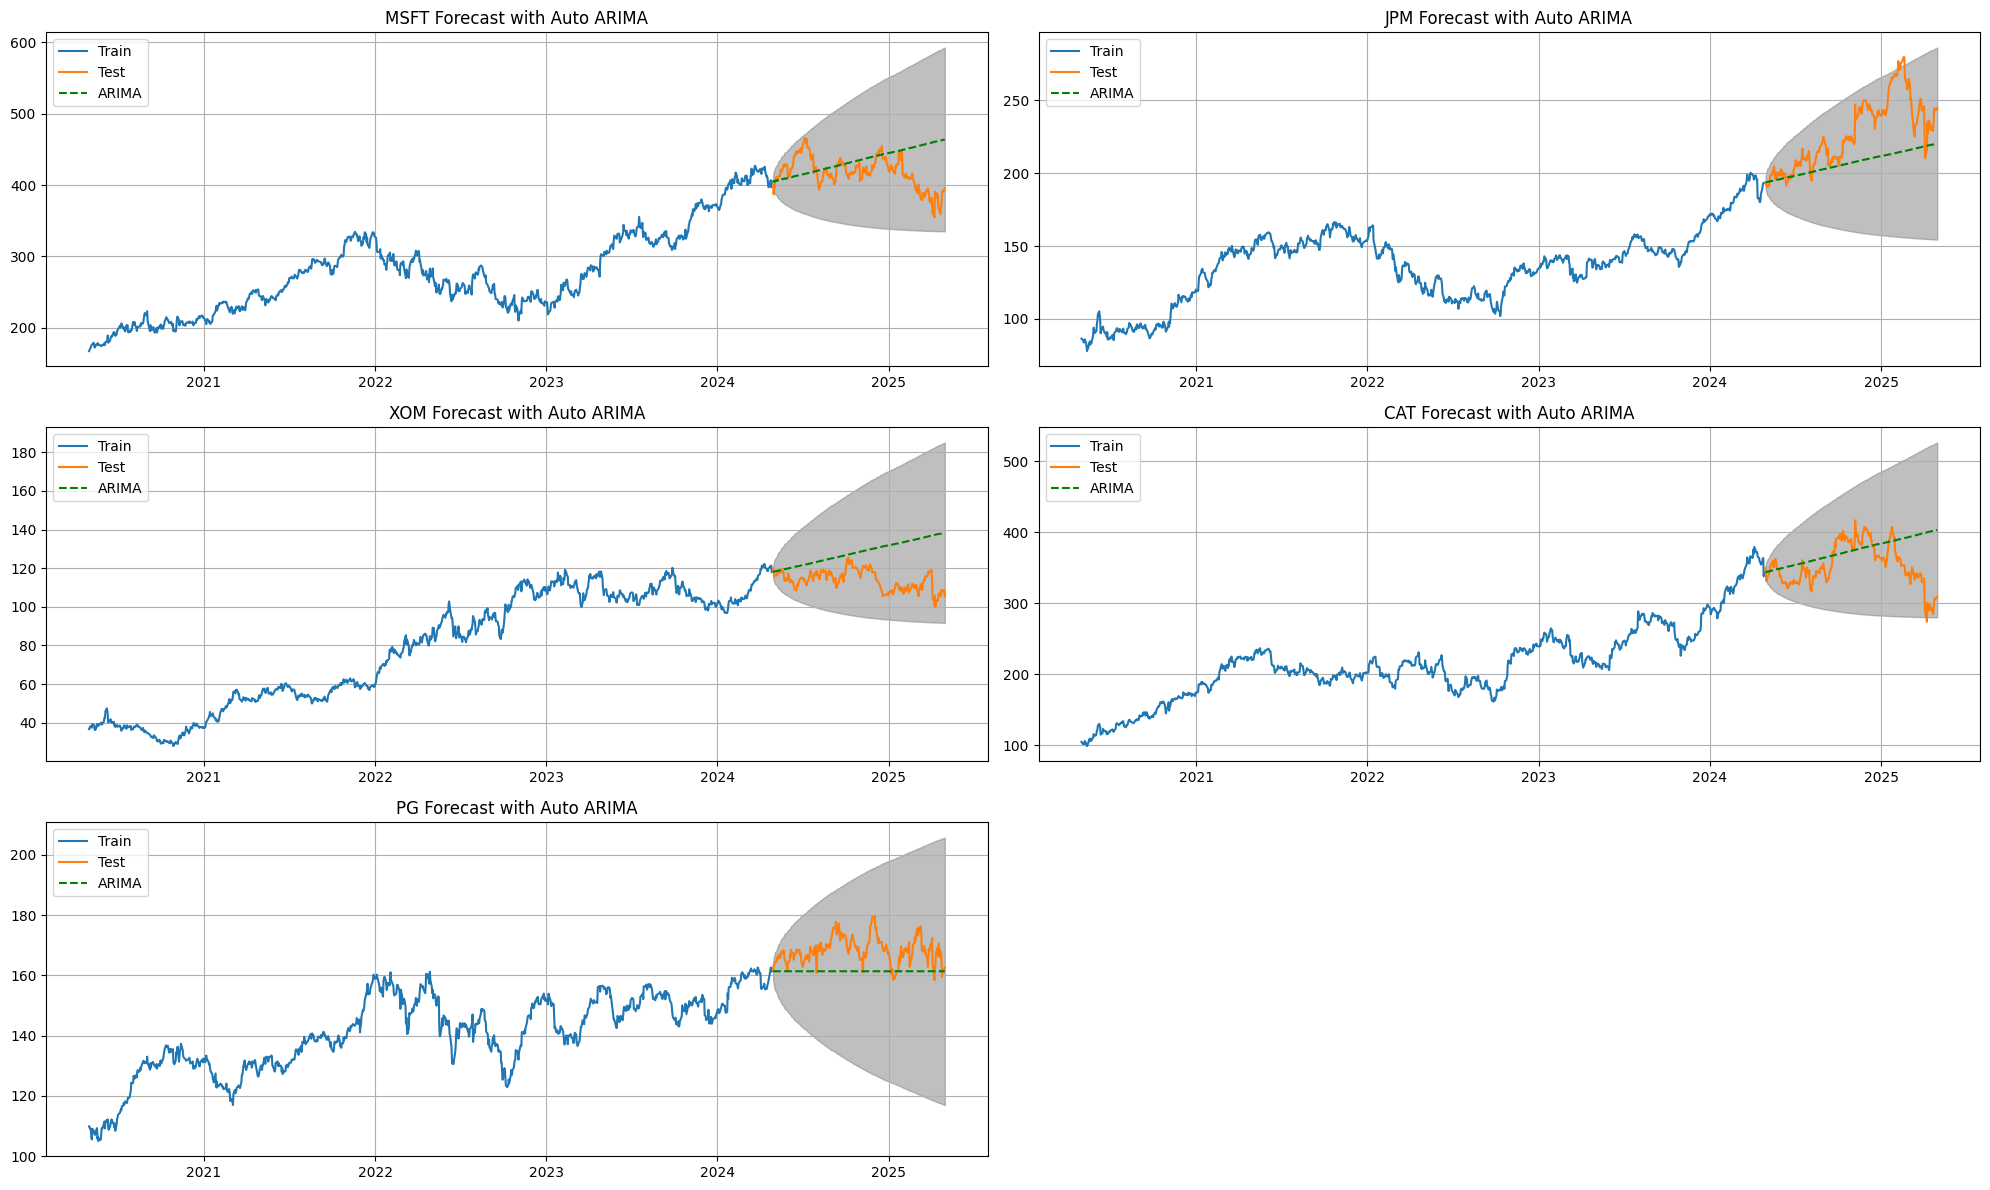

In [3]:
test_ratio      = 0.2
models_arima    = {}
forecasts_arima = {}
actuals_arima   = {}
ci_lower_arima  = {}
ci_upper_arima  = {}

plt.figure(figsize=(20, 12))
for i, t in enumerate(tickers):
    series = close_data[t].dropna()
    series.index = pd.to_datetime(series.index)

    train_size = int(len(series) * (1 - test_ratio))
    train, test = series.iloc[:train_size], series.iloc[train_size:]

    try:
        #Fit ARIMA
        m = auto_arima(train,
                       seasonal=False,
                       stepwise=True,
                       suppress_warnings=True,
                       error_action='ignore')
        models_arima[t] = m

        # Confidence Intervals
        vals, ci = m.predict(n_periods=len(test), return_conf_int=True)
        vals = np.array(vals)
        ci = np.asarray(ci, dtype=float)

        if len(vals) != len(test) or ci.shape[1] != 2:
            raise ValueError("Invalid prediction or confidence interval shape.")

        idx = pd.to_datetime(test.index)
        forecasts_arima[t] = pd.Series(vals, index=idx)
        actuals_arima[t]   = test
        ci_lower_arima[t]  = ci[:, 0]
        ci_upper_arima[t]  = ci[:, 1]

        # Plots
        plt.subplot(3, 2, i + 1)
        plt.plot(train.index, train, label='Train')
        plt.plot(test.index, test, label='Test')
        plt.plot(idx, vals, '--', color='green', label='ARIMA')
        plt.fill_between(idx, ci[:, 0], ci[:, 1], color='gray', alpha=0.5)
        plt.title(f"{t} Forecast with Auto ARIMA")
        plt.legend()
        plt.grid(True)

    except Exception as e:
        print(f"[Warning] ARIMA failed for {t}: {e}")
        forecasts_arima[t] = pd.Series([np.nan] * len(test), index=test.index)
        ci_lower_arima[t]  = np.full(len(test), np.nan)
        ci_upper_arima[t]  = np.full(len(test), np.nan)
        actuals_arima[t]   = test

plt.tight_layout()
plt.show()

# Multivariate Diffusion model + LSTM with UNet

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, df, ctx_len, horiz):
        vals = df.values
        self.windows = []
        for i in range(len(vals) - ctx_len - horiz + 1):
            x = vals[i : i + ctx_len]
            y = vals[i + ctx_len : i + ctx_len + horiz]
            self.windows.append((x, y))
    def __len__(self):
        return len(self.windows)
    def __getitem__(self, idx):
        x, y = self.windows[idx]
        return torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

class UNet1D(nn.Module):
    def __init__(self, in_ch, base_ch=64):
        super().__init__()
        self.conv1 = nn.Conv1d(in_ch, base_ch, 3, padding=1)
        self.conv2 = nn.Conv1d(base_ch, base_ch*2, 3, stride=2, padding=1)
        self.up    = nn.ConvTranspose1d(base_ch*2, base_ch, 2, stride=2)
        self.conv3 = nn.Conv1d(base_ch*2, base_ch, 3, padding=1)
        self.out   = nn.Conv1d(base_ch, in_ch, 1)
    def forward(self, x):
        e1 = torch.relu(self.conv1(x))
        e2 = torch.relu(self.conv2(e1))
        d2 = torch.relu(self.up(e2))
        d1 = torch.relu(self.conv3(torch.cat([d2, e1], 1)))
        return self.out(d1)

class DiffusionUNetLSTM(nn.Module):
    def __init__(self, dim, hid, nl, ts):
        super().__init__()
        self.ts  = ts
        self.lstm= nn.LSTM(dim, hid, nl, batch_first=True)
        self.h2c = nn.Linear(hid, dim)
        self.t2c = nn.Linear(1, dim)
        self.unet= UNet1D(dim, base_ch=128)
        betas = torch.linspace(1e-4, 0.02, ts)
        alphas=1-betas
        self.register_buffer('betas', betas)
        self.register_buffer('alphas_cum', torch.cumprod(alphas, 0))

    def forward(self, x0):
        B, T, D = x0.shape
        t = torch.randint(0, self.ts, (B,), device=x0.device)
        at = self.alphas_cum[t].view(B,1,1)
        noise = torch.randn_like(x0)
        xt = torch.sqrt(at)*x0 + torch.sqrt(1-at)*noise
        _, (hn, _) = self.lstm(x0)
        h = hn[-1]
        xp = xt.permute(0,2,1)
        hm = self.h2c(h).unsqueeze(-1)
        tm = self.t2c((t.float()/self.ts).view(B,1)).unsqueeze(-1)
        cond = xp + hm + tm
        eps  = self.unet(cond).permute(0,2,1)
        return nn.MSELoss()(eps, noise)

    def sample(self, ctx, horiz, n):
        self.eval()
        _, (hn, _) = self.lstm(ctx)
        h = hn[-1]
        all_s=[]
        with torch.no_grad():
            for _ in range(n):
                xt = torch.randn(1, horiz, ctx.shape[2], device=ctx.device)
                for i in reversed(range(self.ts)):
                    xp = xt.permute(0,2,1)
                    hm = self.h2c(h).unsqueeze(-1)
                    tm = self.t2c((torch.tensor([i],device=ctx.device).float()/self.ts).view(1,1)).unsqueeze(-1)
                    cond = xp + hm + tm
                    eps  = self.unet(cond).permute(0,2,1)
                    ai   = self.alphas_cum[i]
                    coef = 1/torch.sqrt(1-self.betas[i])
                    xt   = coef*(xt - (self.betas[i]/torch.sqrt(1-ai))*eps)
                    if i>0:
                        xt = xt + torch.sqrt(self.betas[i])*torch.randn_like(xt)
                all_s.append(xt.detach().cpu().numpy().squeeze(0))
        return np.stack(all_s, axis=0)

# Split Dataset into Train and Test
# Train the Model for 50 epochs

In [5]:

ctx_len    = 60
train_size = int(len(close_data)*(1-test_ratio))
train_df   = close_data.iloc[:train_size]
test_df    = close_data.iloc[train_size:]
horiz      = len(test_df)


scaler_mv       = StandardScaler().fit(train_df.values)
scaled_train    = scaler_mv.transform(train_df.values)
df_train_scaled = pd.DataFrame(scaled_train, index=train_df.index, columns=tickers)

ds_mv    = TimeSeriesDataset(df_train_scaled, ctx_len, horiz)
loader_mv= DataLoader(ds_mv, batch_size=32, shuffle=True)

device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_mv = DiffusionUNetLSTM(len(tickers),128,2,300).to(device)
opt_mv   = torch.optim.Adam(model_mv.parameters(), lr=1e-3)

for ep in range(50):
    tot, cnt = 0, 0
    for xb,_ in loader_mv:
        xb=xb.to(device)
        loss = model_mv(xb)
        opt_mv.zero_grad(); loss.backward(); opt_mv.step()
        tot+=loss.item(); cnt+=1
    print(f"Epoch {ep+1:02d} - Loss: {tot/cnt:.6f}")

Epoch 01 - Loss: 0.560956
Epoch 02 - Loss: 0.255742
Epoch 03 - Loss: 0.216422
Epoch 04 - Loss: 0.219234
Epoch 05 - Loss: 0.179083
Epoch 06 - Loss: 0.166445
Epoch 07 - Loss: 0.164655
Epoch 08 - Loss: 0.158023
Epoch 09 - Loss: 0.153703
Epoch 10 - Loss: 0.147416
Epoch 11 - Loss: 0.132916
Epoch 12 - Loss: 0.148218
Epoch 13 - Loss: 0.151889
Epoch 14 - Loss: 0.141245
Epoch 15 - Loss: 0.132938
Epoch 16 - Loss: 0.143211
Epoch 17 - Loss: 0.126916
Epoch 18 - Loss: 0.138609
Epoch 19 - Loss: 0.147752
Epoch 20 - Loss: 0.136211
Epoch 21 - Loss: 0.133701
Epoch 22 - Loss: 0.131199
Epoch 23 - Loss: 0.143205
Epoch 24 - Loss: 0.129740
Epoch 25 - Loss: 0.137187
Epoch 26 - Loss: 0.125872
Epoch 27 - Loss: 0.126238
Epoch 28 - Loss: 0.134915
Epoch 29 - Loss: 0.147247
Epoch 30 - Loss: 0.129260
Epoch 31 - Loss: 0.121657
Epoch 32 - Loss: 0.134122
Epoch 33 - Loss: 0.122767
Epoch 34 - Loss: 0.122844
Epoch 35 - Loss: 0.133731
Epoch 36 - Loss: 0.133770
Epoch 37 - Loss: 0.122464
Epoch 38 - Loss: 0.134923
Epoch 39 - L

# Forecast using the Train model

In [6]:
ctx_tensor = torch.tensor(df_train_scaled.values[-ctx_len:], dtype=torch.float).unsqueeze(0).to(device)
samps_mv   = model_mv.sample(ctx_tensor, horiz, 100)

dmed_mv    = np.median(samps_mv, axis=0)
dl_mv, dh_mv = np.percentile(samps_mv, (2.5,97.5), axis=0)

res_med_mv = scaler_mv.inverse_transform(dmed_mv)
res_lo_mv  = scaler_mv.inverse_transform(dl_mv)
res_hi_mv  = scaler_mv.inverse_transform(dh_mv)

fmt_med_mv = pd.DataFrame(res_med_mv, index=test_df.index, columns=tickers)
fmt_lo_mv  = pd.DataFrame(res_lo_mv, index=test_df.index, columns=tickers)
fmt_hi_mv  = pd.DataFrame(res_hi_mv, index=test_df.index, columns=tickers)

# Plot ARIMA vs Diffusion forecasts

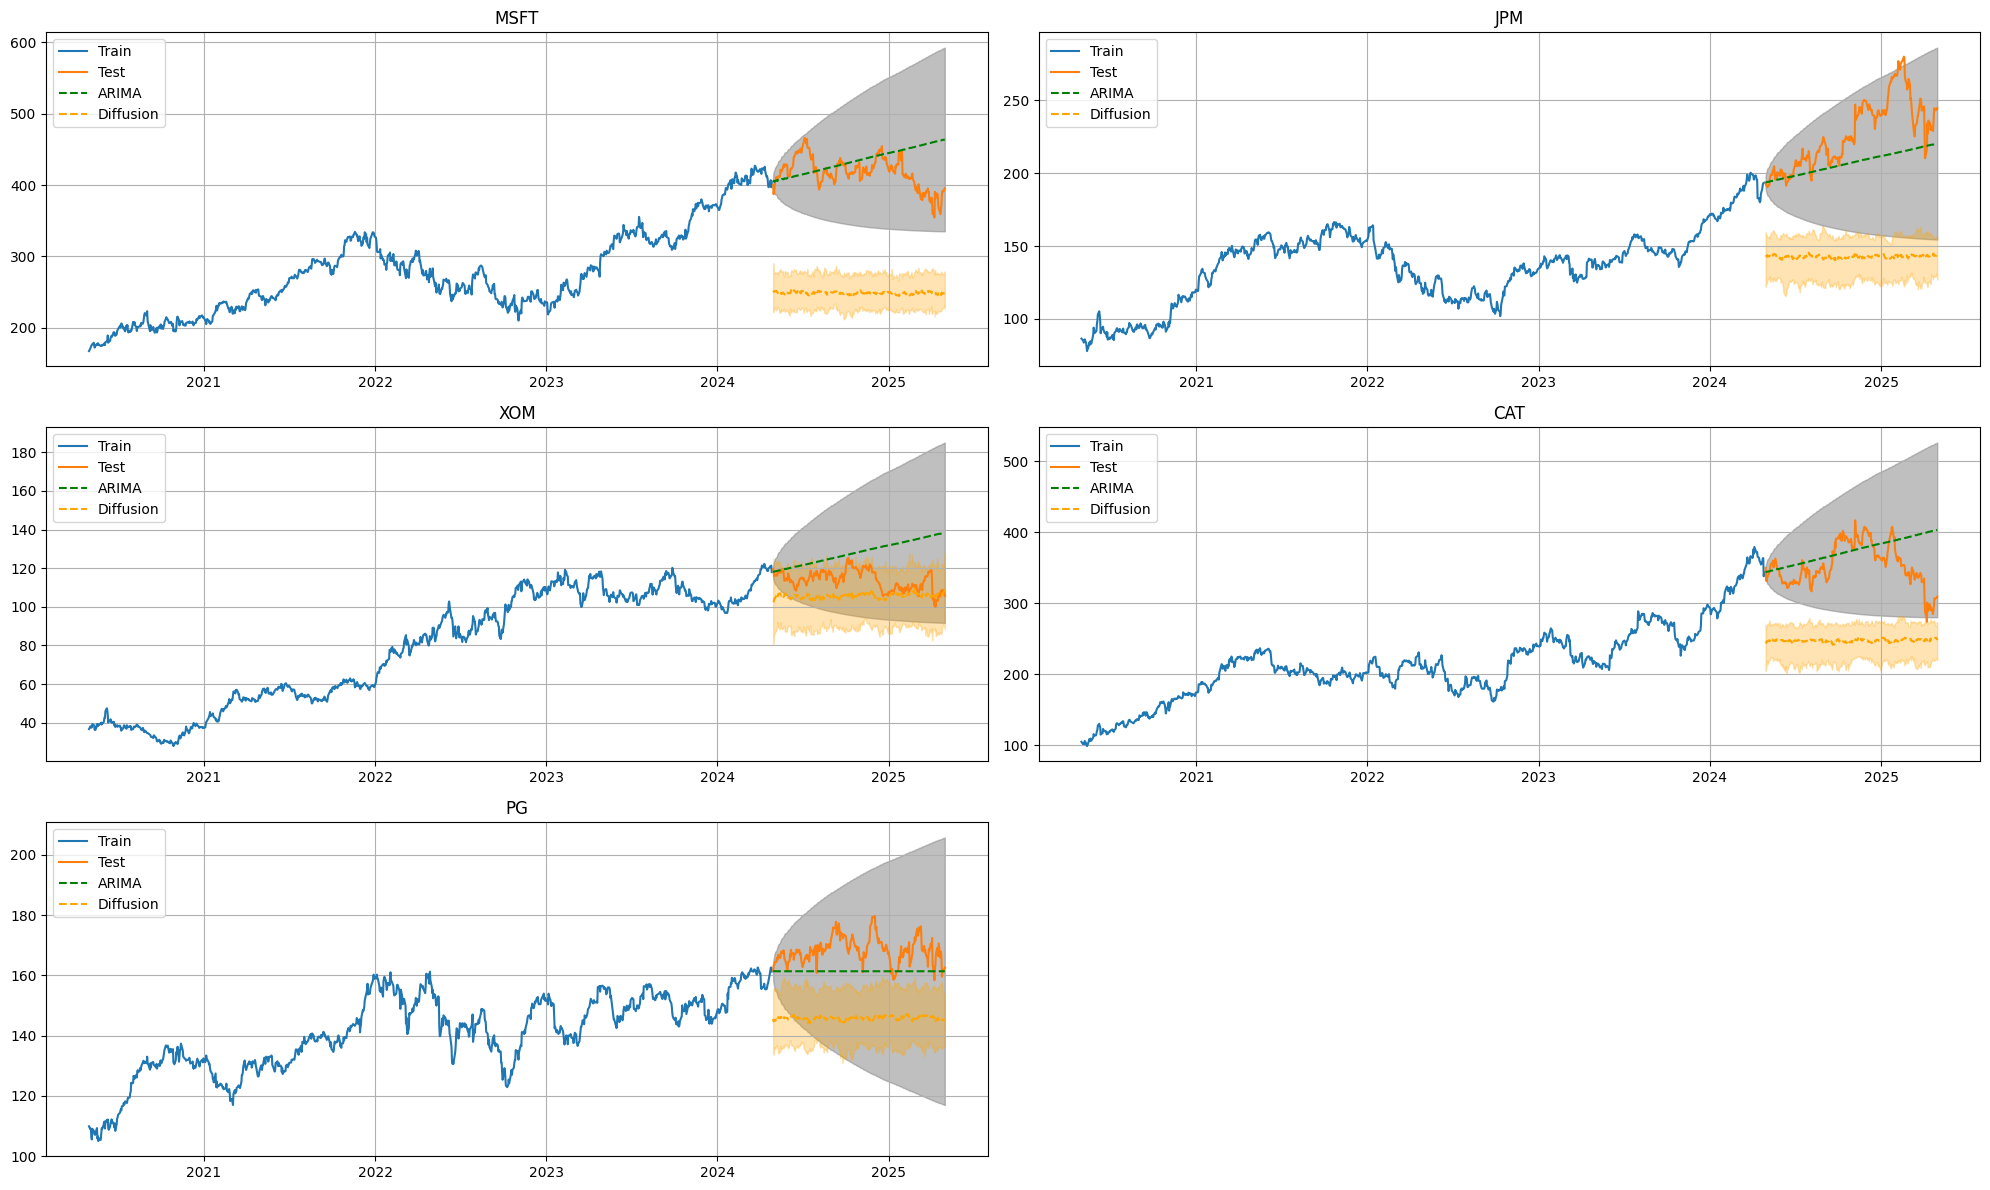

In [8]:
plt.figure(figsize=(20,12))
for i, t in enumerate(tickers):
    tr = close_data[t].iloc[:train_size]
    te = close_data[t].iloc[train_size:]
    ar = forecasts_arima[t]
    mv = fmt_med_mv[t]

    plt.subplot(3,2,i+1)
    plt.plot(tr.index, tr, label='Train')
    plt.plot(te.index, te, label='Test')
    plt.plot(ar.index, ar, '--', color='green', label='ARIMA')
    plt.fill_between(ar.index, ci_lower_arima[t], ci_upper_arima[t], color='gray', alpha=0.5)
    plt.plot(mv.index, mv, '--', color='orange', label='Diffusion')
    plt.fill_between(mv.index, fmt_lo_mv[t], fmt_hi_mv[t], color='orange', alpha=0.3)
    plt.title(t)
    plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()

# Compute RMSE MAE metrics

In [9]:
res_ar, res_mv = [], []
for t in tickers:
    arr = actuals_arima[t]
    arp = forecasts_arima[t]

    # Align indexes and get rid of NaNs 
    arr, arp = arr.align(arp, join='inner')
    valid_idx = ~arp.isna()
    if valid_idx.sum() == 0:
        print(f"[Warning] Skipping ARIMA metrics for {t} due to NaNs.")
        res_ar.append({'Ticker': t, 'ARIMA_MAE': np.nan, 'ARIMA_RMSE': np.nan})
    else:
        mae_ar  = np.mean(np.abs(arr[valid_idx] - arp[valid_idx]))
        rmse_ar = np.sqrt(np.mean((arr[valid_idx] - arp[valid_idx])**2))
        res_ar.append({'Ticker': t, 'ARIMA_MAE': mae_ar, 'ARIMA_RMSE': rmse_ar})

    # Diffusion forecast 
    yv = test_df[t].values
    pv = fmt_med_mv[t].values
    mae_mv  = np.mean(np.abs(pv - yv))
    rmse_mv = np.sqrt(np.mean((pv - yv)**2))
    res_mv.append({'Ticker': t, 'MV_MAE': mae_mv, 'MV_RMSE': rmse_mv})

df_ar = pd.DataFrame(res_ar).set_index('Ticker')
df_mv = pd.DataFrame(res_mv).set_index('Ticker')
metrics_combined = pd.concat([df_ar, df_mv], axis=1).round(2)
print(metrics_combined)

        ARIMA_MAE  ARIMA_RMSE  MV_MAE  MV_RMSE
Ticker                                        
MSFT        27.63       37.58  168.42   169.84
JPM         19.98       26.04   83.74    86.81
XOM         14.36       17.12    8.43     9.68
CAT         29.18       39.61  106.46   110.56
PG           7.12        8.13   22.54    22.94


# Compute Secondary dianostics

In [10]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

#  Volatility
def rolling_volatility(series, window=20):
    return series.pct_change().rolling(window).std().mean()

volatility = {t: rolling_volatility(close_data[t]) for t in tickers}

#  SNR (Signal-to-Noise Ratio)
snr = {}
for t in tickers:
    series = close_data[t].dropna()
    ma = series.rolling(window=10, min_periods=1).mean()
    signal = np.var(ma)
    noise = np.var(series - ma)
    snr[t] = signal / noise if noise != 0 else np.nan

# Trend Strength
def trend_strength(ts):
    try:
        res = seasonal_decompose(ts, period=30, model='additive', extrapolate_trend='freq')
        return 1 - (np.var(res.resid.dropna()) / np.var(res.trend.dropna()))
    except:
        return np.nan

trend_scores = {t: trend_strength(close_data[t]) for t in tickers}

# Nonlinearity 
nonlinearity = {}
for t in tickers:
    series = close_data[t].dropna().values
    if len(series) > 2:
        X = np.array(series[:-1]).reshape(-1, 1)
        y = np.array(series[1:])
        lin_model = LinearRegression().fit(X, y)
        pred = lin_model.predict(X)
        residual = y - pred
        nonlinearity[t] = np.var(residual) / np.var(y) if np.var(y) != 0 else np.nan
    else:
        nonlinearity[t] = np.nan

# Autocorrelation (Lag 1)
acf_scores = {t: close_data[t].autocorr(lag=1) for t in tickers}

#  RMSE Difference (MV - ARIMA) 
rmse_diff = (df_mv['MV_RMSE'] - df_ar['ARIMA_RMSE']).to_dict()

# Summary DataFrame 
diag_df = pd.DataFrame({
    'RMSE_Diff': pd.Series(rmse_diff),
    'Volatility': pd.Series(volatility),
    'SNR': pd.Series(snr),
    'TrendStrength': pd.Series(trend_scores),
    'Nonlinearity': pd.Series(nonlinearity),
    'Autocorr(Lag1)': pd.Series(acf_scores)
}).round(4)

print("Diffusion Model Diagnostics Summary ")
print(diag_df)



Diffusion Model Diagnostics Summary 
      RMSE_Diff  Volatility       SNR  TrendStrength  Nonlinearity  \
MSFT   132.2560      0.0162  105.6967         0.9908        0.0041   
JPM     60.7690      0.0158   94.4886         0.9883        0.0036   
XOM     -7.4386      0.0182  142.2187         0.9933        0.0027   
CAT     70.9575      0.0181   87.5973         0.9895        0.0039   
PG      14.8081      0.0103   40.7347         0.9779        0.0102   

      Autocorr(Lag1)  
MSFT          0.9980  
JPM           0.9982  
XOM           0.9987  
CAT           0.9981  
PG            0.9949  
